In [38]:
data_fold = "data/stanford/"
method = "pretrain"     # pretrain or finetune
isolates = [3, 7]       # for get the selected pos
chromosome = "6"
pval_thresh = 1e-5
part = "top"            # top, low
k_reads = 0.1
pos_range = 32          # 32 for stanford, 18 for tcga-skcm

In [39]:
import torch

import umap
import numpy as np
import pandas as pd
import sklearn.decomposition
import sklearn.linear_model
import sklearn.metrics

import os
import importlib
import seaborn as sns
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.patches

import selector

""" function """

def pearsonCorrelation(x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
    x1centered = x1 - x1.mean(axis=1, keepdims=True)        # (N1, 768)
    x2centered = x2 - x2.mean(axis=1, keepdims=True)        # (N2, 768)
    numerator = np.dot(x1centered, x2centered.T)            # (N1, N2)
    x1var = np.sum(x1centered**2, axis=1, keepdims=True)    # (N1,  1)
    x2var = np.sum(x2centered**2, axis=1, keepdims=True)    # (N2,  1)
    denominator = np.sqrt(np.dot(x1var, x2var.T))           # (N1, N2)
    return numerator / denominator                          # (N1, N2)

""" profile """

# dataset
profile = pd.read_csv(os.path.join(data_fold, "profile.txt"))
# Isolate string (i.e. su001) -> int (i.e. 1)
profile["Isolate"] = profile["Isolate"].apply(lambda x: int(x[2:]))
# Treatment pre/post -> 0/1
profile["Treatment"] = profile["Treatment"].apply(lambda x: int(not "pre" in x))
# Sort by Isolate (1 to 8), Treatment (pre to post), and Tissue (normal to BCC)
profile = profile.sort_values(
    by=["Isolate", "Treatment", "Tissue"], ascending=[True, True, False]
).reset_index(drop=True)
# only keep run, isolate, treatment, tissue
profile = profile[["Run", "Isolate", "Treatment", "Tissue"]]

In [40]:
import selector
importlib.reload(selector)

runs = profile["Run"].to_list()

# feature selector
selection = selector.Selector("data/feature", ascending=False)

# embd after feature selection, note that there are nan row
embd = {}
for run in runs:
    embd_path = os.path.join(data_fold, f"embd-{method}/{run}/{chromosome}.npy")
    embd[run] = embd_selected = selection.apply(
        embd_path=embd_path, k_read=k_reads, pos_range=pos_range
    )
# combine all embd, remove all the nan row
embd_all = np.concatenate([embd[run] for run in runs], axis=0)
embd_all = embd_all[~np.isnan(embd_all).all(axis=1)]
# calculate the mean and fill the embd nan row with mean
# so that these nan will be 0 in pca
mean = np.mean(embd_all, axis=0)
for run in runs:
    embd[run] = np.where(np.isnan(embd[run]), mean, embd[run])
# pca using embd without nan row, len(runs) * [N,768] -> [len(runs), N]
pca_reducer = sklearn.decomposition.PCA(n_components=1)
pca_reducer.fit(embd_all)
pca = np.array([pca_reducer.transform(embd[run]) for run in runs]).squeeze()

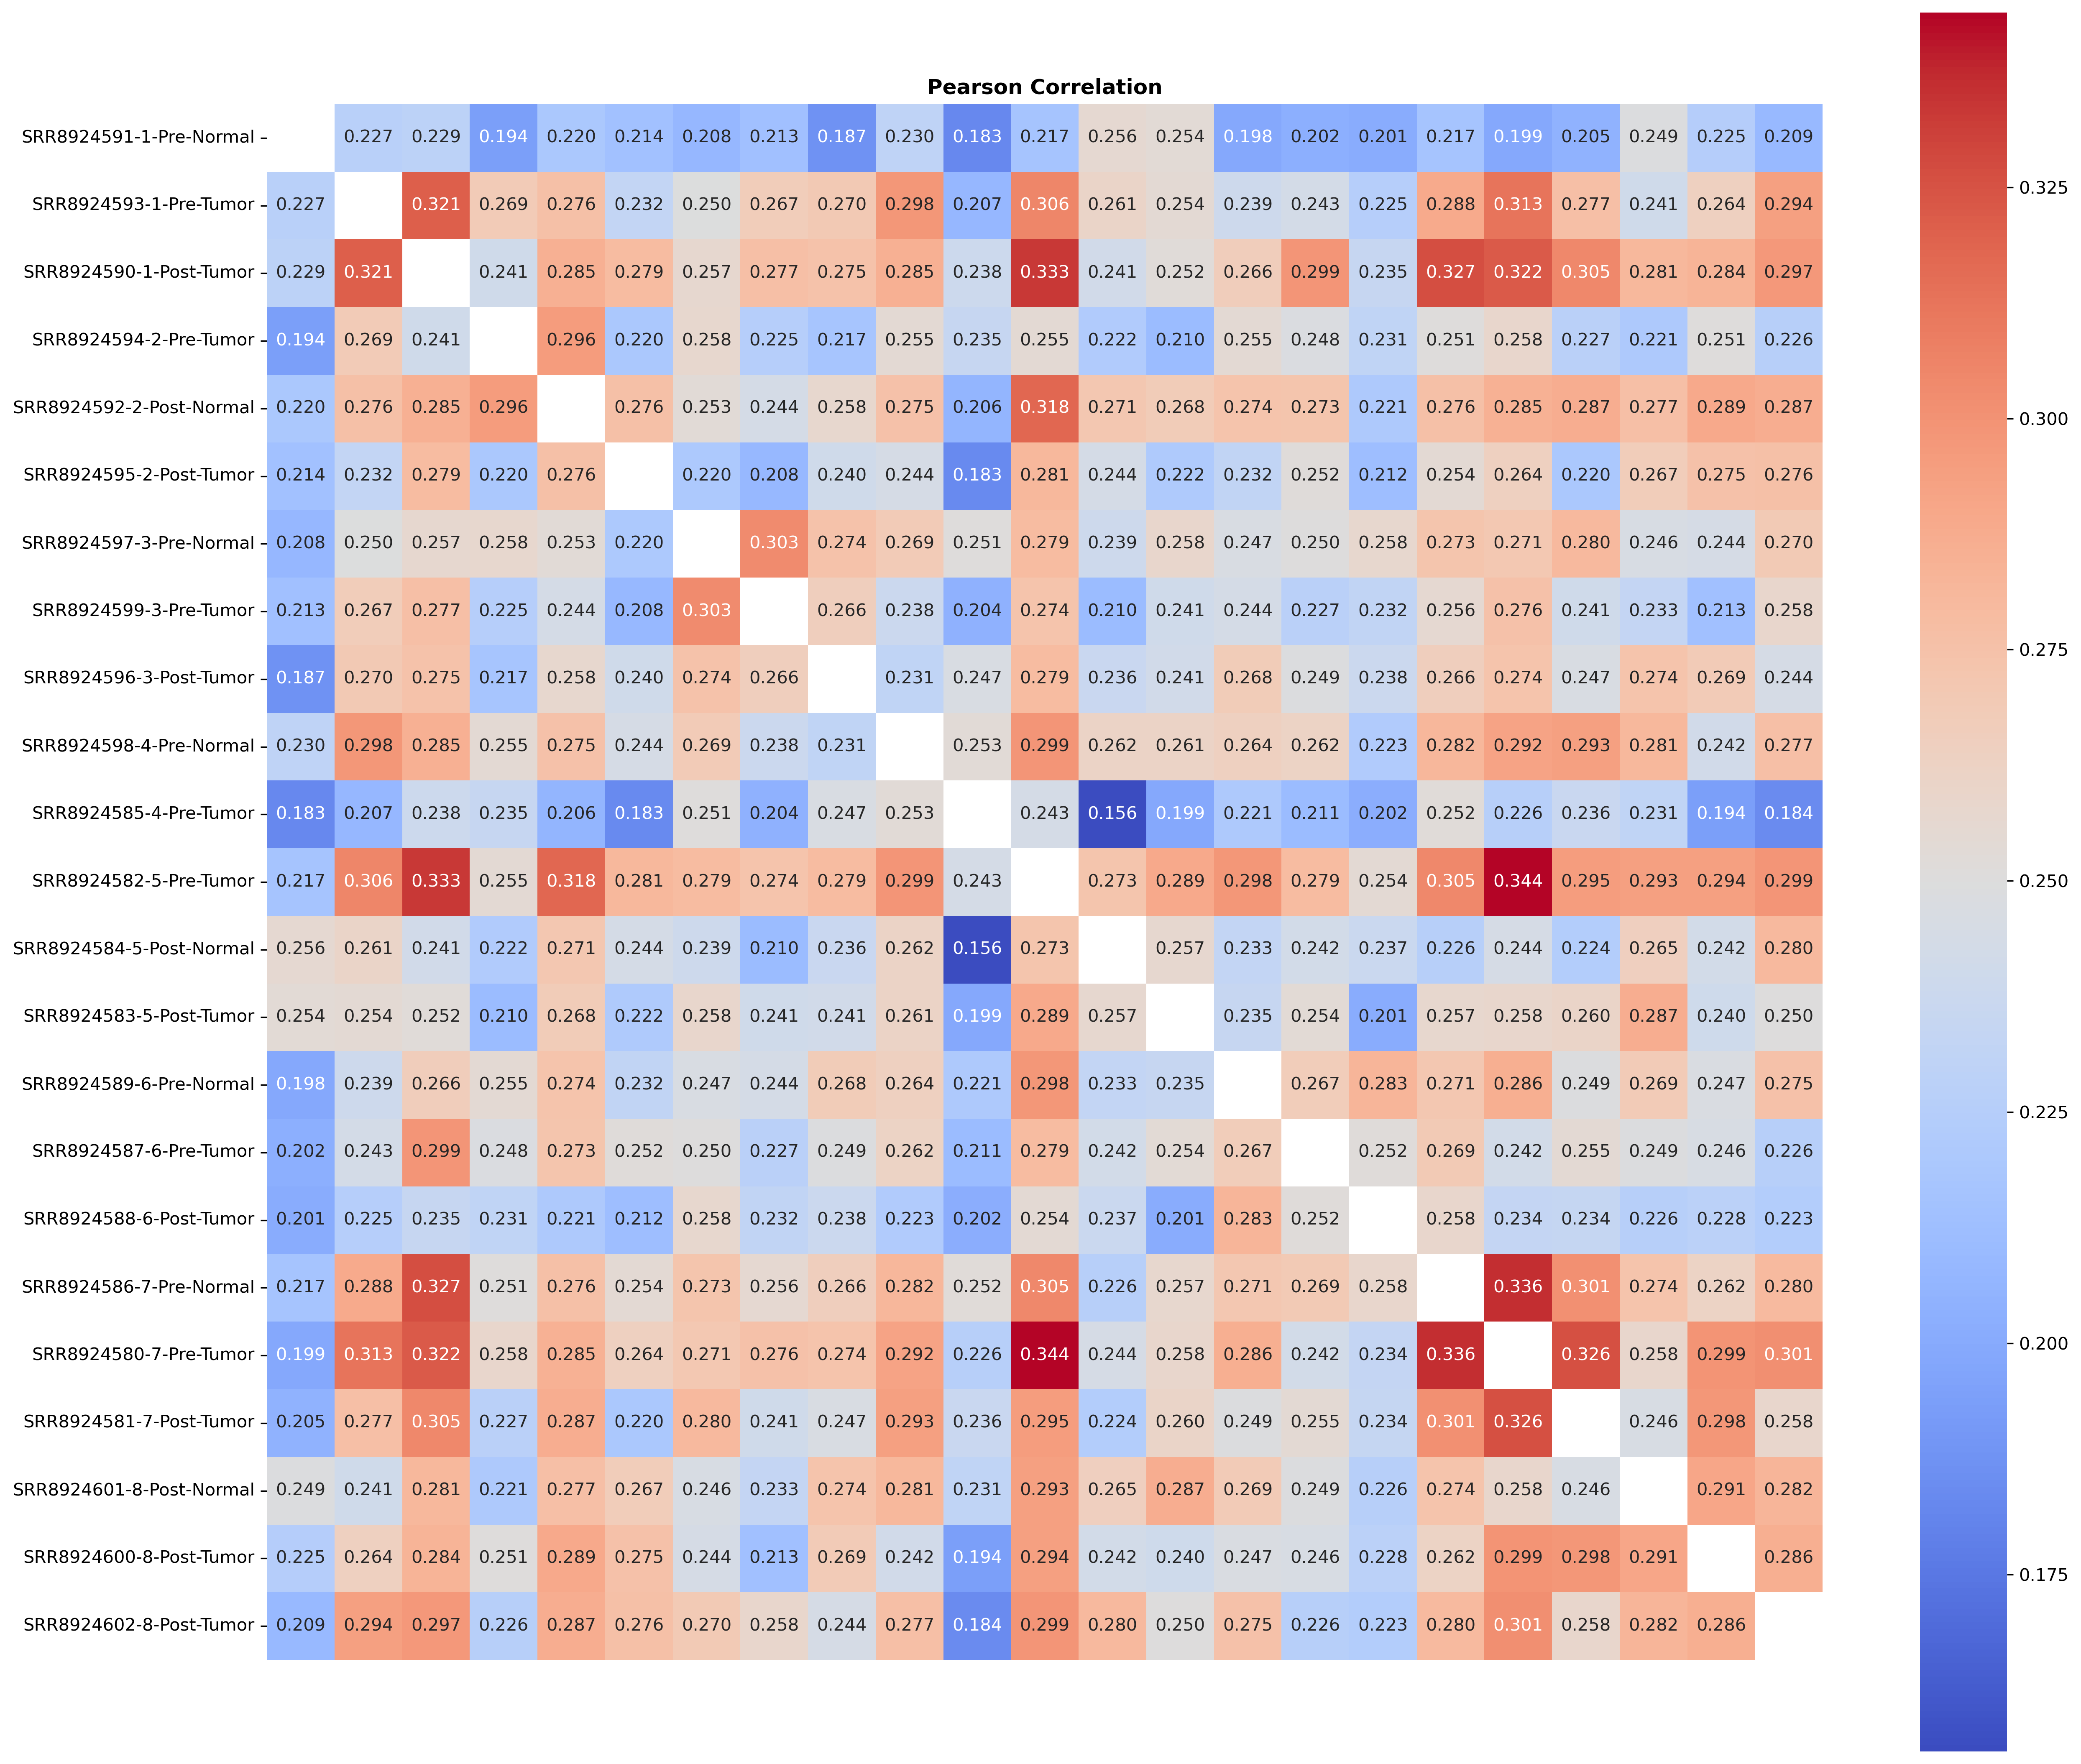

In [42]:
""" plot correlation heat map of runs for selected pos"""

runs = profile["Run"].to_list()

# calculate the correlation between each pair of runs
heat_map = pearsonCorrelation(pca, pca)     # [len(runs), len(runs)]
for i in range(len(heat_map)): heat_map[i, i] = np.nan

# plot the heat map 6*6 
labels = []
for run in runs:
    id, isolate, treatment, tissue = profile[profile["Run"] == run].iloc[0]
    labels.append("{}-{}-{}-{}".format(
            id, isolate,
            "Pre" if treatment == 0 else "Post", 
            "Normal" if "normal" in tissue else "Tumor"
        ))
plt.figure(dpi=300, figsize=(20, 18))
sns.heatmap(
    heat_map, annot=True, fmt=".3f", cmap="coolwarm", square=True,
    yticklabels=labels, xticklabels=False
)
plt.title("Pearson Correlation", fontweight='bold')
plt.show()

In [41]:
lr = sklearn.linear_model.LogisticRegression()
t = profile["Treatment"].to_numpy()
lr.fit(pca, t)
y = lr.predict(pca)
print(sklearn.metrics.accuracy_score(t, y))

1.0


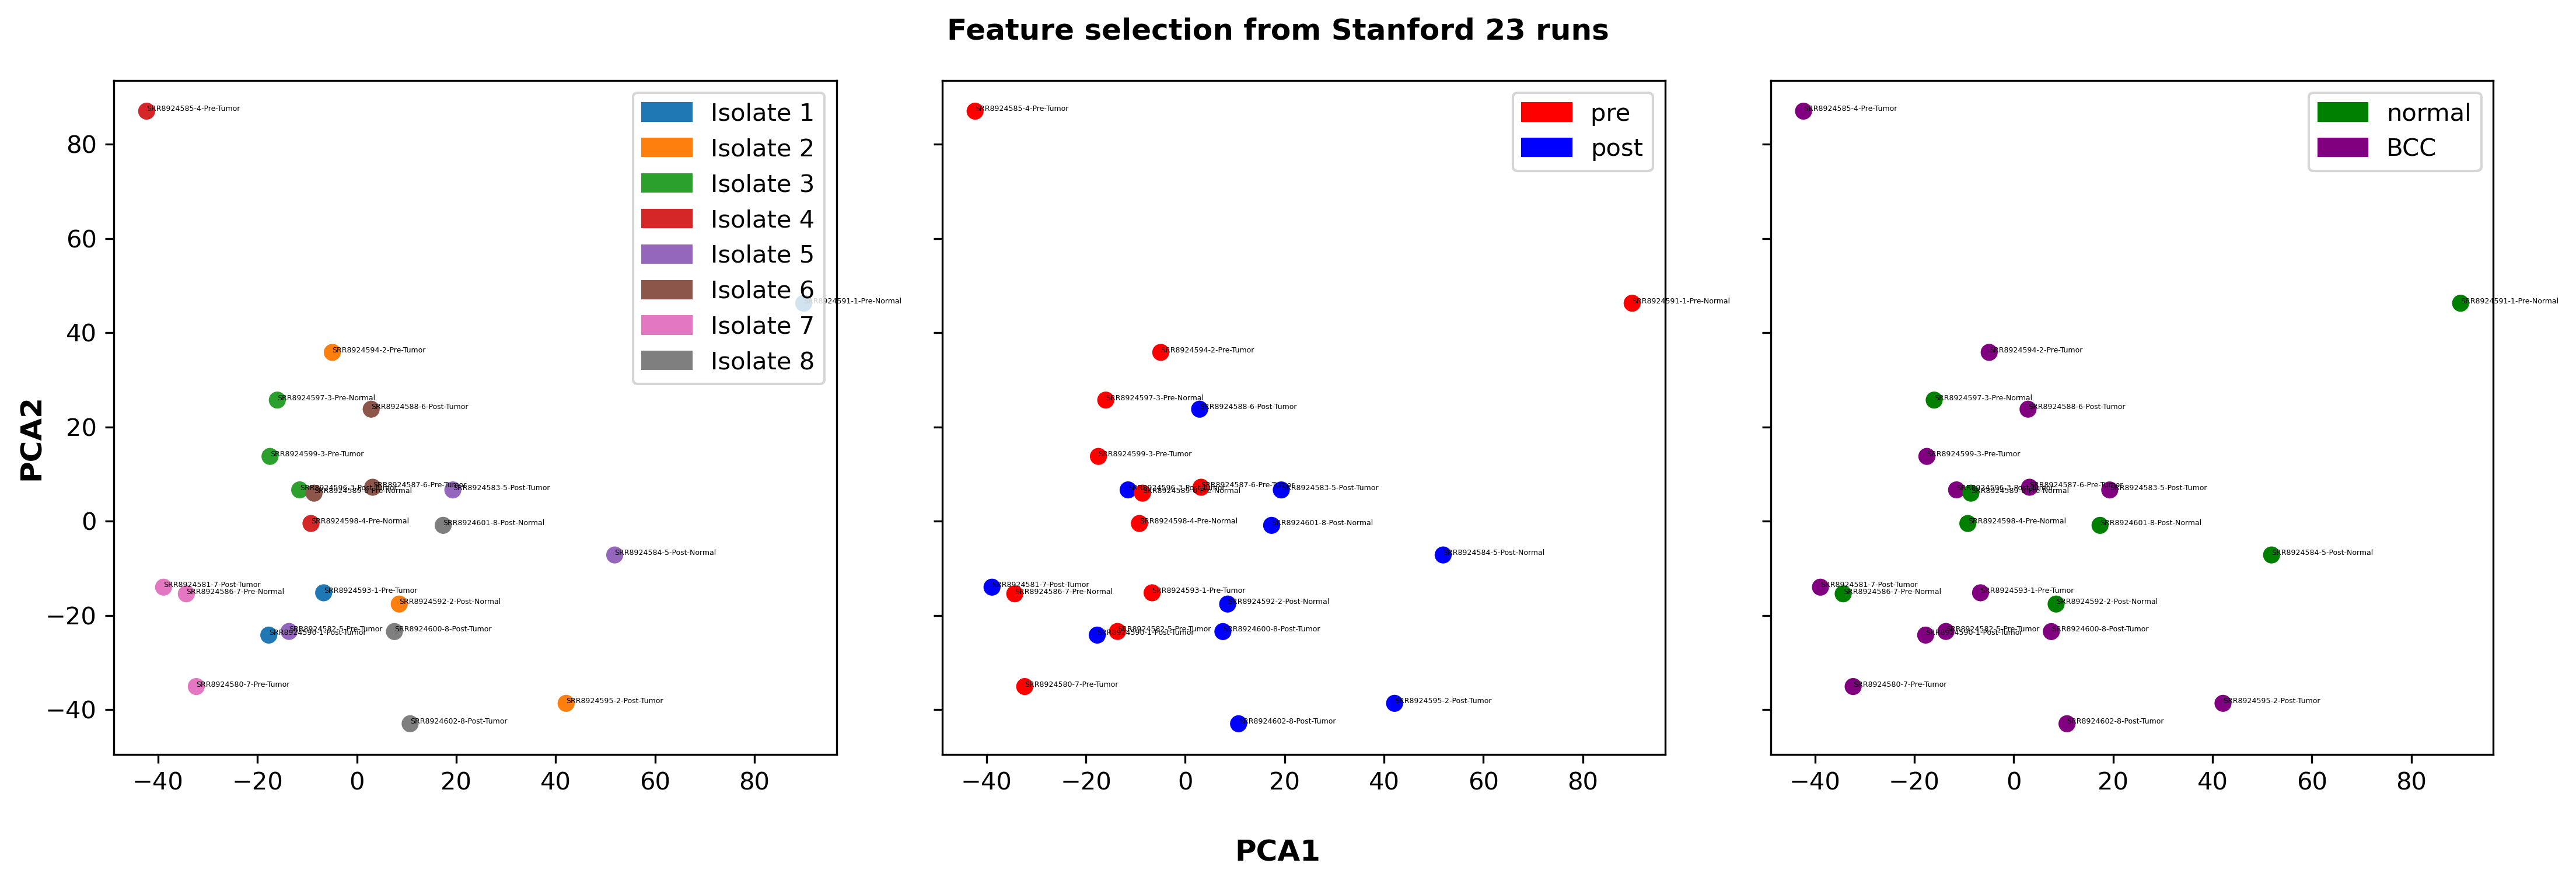

In [43]:
""" plot scatter of PCA1 and PCA2 of all runs """

# [len(runs), N] -> [len(runs), 2], for plot
pca_temp = sklearn.decomposition.PCA(n_components=2).fit_transform(pca)

# plot scatter of PCA1 and PCA2
labels = []
for run in runs:
    id, isolate, treatment, tissue = profile[profile["Run"] == run].iloc[0]
    treatment = "Pre" if treatment == 0 else "Post"
    tissue = "Normal" if "normal" in tissue else "Tumor"
    labels.append(f"{id}-{isolate}-{treatment}-{tissue}")
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True, dpi=300)
# color by isolate
colors = [f"C{i}" for i in range(8)]
axs[0].scatter(pca_temp[:, 0], pca_temp[:, 1], c=[colors[profile[profile["Run"] == run].iloc[0]["Isolate"]-1] for run in runs])
for i in range(len(runs)):
    axs[0].text(pca_temp[i, 0], pca_temp[i, 1], labels[i], fontsize=3)
axs[0].legend(
    handles=[
        matplotlib.patches.Patch(color=colors[i], label=f"Isolate {i+1}") for i in range(8)
    ], loc="upper right", ncol=1,
)
# color by treatment
colors = ["red" if profile[profile["Run"] == run].iloc[0]["Treatment"] == 0 else "blue" for run in runs]
axs[1].scatter(pca_temp[:, 0], pca_temp[:, 1], c=colors)
for i in range(len(runs)):
    axs[1].text(pca_temp[i, 0], pca_temp[i, 1], labels[i], fontsize=3)
axs[1].legend(
    handles=[
        matplotlib.patches.Patch(color="r", label="pre "), 
        matplotlib.patches.Patch(color="b", label="post")
    ], loc="upper right", ncol=1,
)
# color by tissue
colors = ["green" if "normal" in profile[profile["Run"] == run].iloc[0]["Tissue"] else "purple" for run in runs]
axs[2].scatter(pca_temp[:, 0], pca_temp[:, 1], c=colors)
for i in range(len(runs)):
    axs[2].text(pca_temp[i, 0], pca_temp[i, 1], labels[i], fontsize=3)
axs[2].legend(
    handles=[
        matplotlib.patches.Patch(color="g", label="normal"), 
        matplotlib.patches.Patch(color="purple", label="BCC")
    ], loc="upper right", ncol=1,
)
fig.suptitle(f"Feature selection from Stanford 23 runs", fontweight='bold')
fig.supxlabel("PCA1", fontweight='bold')
fig.supylabel("PCA2", fontweight='bold')
fig.tight_layout()
fig.show()

In [ ]:
""" Plot Hexbin N * N+1"""

"""
gridsize = 80
vmin, vmax = 4, 64
fontsize = 18

fig, axs = plt.subplots(
    len(runs), len(runs)+1, figsize=(35, 30), 
    sharex=True, sharey=True
)
# plot
for i in range(len(runs)):
    # plot umpa of sample i before filter in diagonal
    axs[i, i].hexbin(
        umap[runs[i]][:, 0], umap[runs[i]][:, 1], 
        cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax,
    )
    # plot umap of (i, :) and (:, i) after filter by distance (i, j)
    for j in range(i+1, len(runs)):
        # umap of (i, :)
        axs[i, j].hexbin(
            umap[runs[i]][:, 0], umap[runs[i]][:, 1], 
            cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax/2,
        )
        # umap of (:, i)
        axs[j, i].hexbin(
            umap[runs[j]][:, 0], umap[runs[j]][:, 1], 
            cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax/2,
        )
    # plot umap of (i, len(runs)) of combine all filter
    axs[i, len(runs)].hexbin(
        umap[runs[i]][:, 0], 
        umap[runs[i]][:, 1], 
        cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax/2,
    )
# set up axis and label
for i in range(len(runs)):
    id, isolate, treatment, tissue = profile[profile["Run"] == runs[i]].iloc[0]
    treatment = "Pre" if treatment == 0 else "Post"
    tissue = "Normal" if "normal" in tissue else "Tumor"
    info = f"{id} - {isolate} - {treatment} - {tissue}"
    axs[0,  i].set_xlabel(info, fontsize=fontsize, fontweight='bold')
    axs[0,  i].xaxis.set_label_position("top")
    axs[0, len(runs)].set_xlabel("All Selected Reads", fontsize=fontsize, fontweight='bold')
    axs[0, len(runs)].xaxis.set_label_position("top")
    axs[i, -1].set_ylabel(info, fontsize=fontsize, fontweight='bold')
    axs[i, -1].yaxis.set_label_position("right")
    for j in range(len(runs)+1):
        axs[i, j].set_aspect("equal")
        axs[i, j].set_xlim(-22, 22)
        axs[i, j].set_ylim(-22, 22)
fig.supxlabel("UMAP1", fontsize=fontsize, fontweight='bold', y=0.004)
fig.supylabel("UMAP2", fontsize=fontsize, fontweight='bold', x=0.008)
fig.tight_layout()
fig.savefig("temp.png", dpi=500)
fig.show()
"""

""" Plot Hexbin of all samples """

"""
gridsize = 80
vmin, vmax = 4, 64
fontsize = 18

# hexbin, split by isolate
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
umap_isolates = [None, None]
for i in range(len(runs)):
    axs_index = 0 if profile[profile["Run"] == runs[i]]["Isolate"].values[0] == 3 else 1
    if umap_isolates[axs_index] is None:
        umap_isolates[axs_index] = umap[runs[i]]
    else:
        umap_isolates[axs_index] = np.concatenate(
            [umap_isolates[axs_index], umap[runs[i]]]
        )
for axs_index in range(2):
    axs[axs_index].hexbin(
        umap_isolates[axs_index][:, 0], umap_isolates[axs_index][:, 1], 
        cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax,
    )
    axs[axs_index].set_xlim(-22, 22)
    axs[axs_index].set_ylim(-22, 22)
    axs[axs_index].set_title(
        "su003" if axs_index == 0 else "su007", 
        fontweight='bold', fontsize=fontsize
    )
fig.tight_layout()
fig.show()

# hexbin, split by treatment
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
umap_treatments = [None, None]
for i in range(len(runs)):
    axs_index = profile[profile["Run"] == runs[i]]["Treatment"].values[0]
    if umap_treatments[axs_index] is None:
        umap_treatments[axs_index] = umap[runs[i]]
    else:
        umap_treatments[axs_index] = np.concatenate(
            [umap_treatments[axs_index], umap[runs[i]]]
        )
for axs_index in range(2):
    axs[axs_index].hexbin(
        umap_treatments[axs_index][:, 0], umap_treatments[axs_index][:, 1], 
        cmap="Reds", gridsize=gridsize,
        vmin = vmin if axs_index == 0 else (vmin/2),
        vmax = vmax if axs_index == 0 else (vmax/2)
    )
    axs[axs_index].set_xlim(-22, 22)
    axs[axs_index].set_ylim(-22, 22)
    axs[axs_index].set_title(
        "Pre" if axs_index == 0 else "Post", 
        fontweight='bold', fontsize=fontsize
    )
fig.tight_layout()
fig.show()
"""